### Calculate Structure, Amplitude and Location Errors based on Wernli et al 2008. (https://journals.ametsoc.org/doi/abs/10.1175/2008MWR2415.1)

Note: 

1) Although here it is implemented in a global grid because the calculations were not done in an area averaged way this implementation might be best for a smaller domain sizes.


In [1]:
import xarray as xr
import numpy as np
from scipy import ndimage
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
da_obs=xr.open_dataset('/data/suvarchal/testing_transfers/abhi/gfs_0.0C1-2.0C2_prec_2008_lead01d.nc')
da_fcst=xr.open_dataset('/data/suvarchal/testing_transfers/abhi/gfs_0.0C1-2.0C2_prec_2008_lead02d.nc')

In [4]:
#Also do any spatial selection for a domain use .sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
prec_obs=da_obs.var59.isel(time=1)*86400
prec_fcst=da_fcst.var59.isel(time=0)*86400

In [5]:
lon,lat=np.meshgrid(prec_obs.lon,prec_obs.lat)

#### Check thresholding for finding precipitation objects, later on properties on these objects will be evaluated.

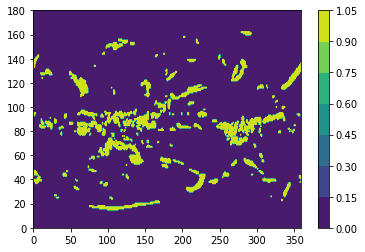

In [6]:
#Threshold precip and make it binary
tprec_fcst=np.where(prec_fcst>=10,1,0)
plt.contourf(tprec_fcst)
plt.colorbar()

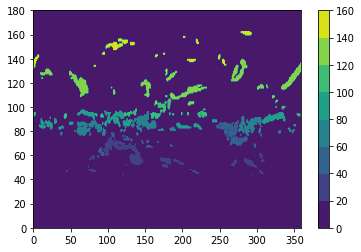

In [7]:
#this is structure for catching objects, default structure is [[0,1,0],[1,1,1],[0,1,0]]
#by using this structure each object will be a closed contour of threshold. 
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]   
#Label different objects found by numbers.
lbl,num = ndimage.label(tprec_fcst,s)
plt.contourf(lbl)
plt.colorbar()

#### Amplitude Component is normalized difference of domain averaged precip 

In [8]:
def Amplitude(fcst,obs):
    "Note: area averaging not done"
    "This function also handles time dimension when present"
    Dm=fcst.mean(dim=['lon','lat']) #Domain average precip
    Do=obs.mean(dim=['lon','lat'])
    return (Dm-Do)/0.5*(Dm+Do)

In [9]:
#Amplitude component
A=Amplitude(prec_fcst,prec_obs)
print("Amplitude error component {}".format(A.values))

Amplitude error component -2.7679697072187155


### Location component comprises of two parts. 
#### First part measures normalized distance between forecast and observational center of mass of precipitation fields.
#### Second part measures avarage distance between precipitation objects (based on some threshold) and total precipiation center of mass.
#### Sum of both parts will give location error, it will have two dimensions lat and lon, that can be used for plotting.


In [10]:
def calc_X(pr):
    "Calculates center of mass of a field"
    "Return values center of mass are based on matrix indices and not lat and lon"
    X=ndimage.measurements.center_of_mass(pr.values)    
    return X

In [11]:
Xm=calc_X(prec_fcst) # Center of Mass in index
Xo=calc_X(prec_obs)
print("Center of mass of forecast and obs in matrix index coordinates {} ,{}".format(Xm,Xo)) 

Center of mass of forecast and obs in matrix index coordinates (89.4002427831595, 182.36195242500384) ,(88.4539496641343, 180.8265573279738)


Interestingly obs and forecast center of mass of global precip differ by a few degrees in this dataset even at lead 1 day lead.

In [12]:
#below is to conververt matrix indices to lat lon coordinates, most 
lat_interp_func=interpolate.interp1d(np.arange(0,len(da_fcst.lat.values)),da_fcst.lat.values)
lon_interp_func=interpolate.interp1d(np.arange(0,len(da_fcst.lon.values)),da_fcst.lon.values)

Xmd=lat_interp_func(Xm[0]),lon_interp_func(Xm[1])
Xod=lat_interp_func(Xo[0]),lon_interp_func(Xo[1])
print("Center of mass of forecast and obs in lat lon degress {},{}".format(Xmd,Xod))

Center of mass of forecast and obs in lat lon degress (array(0.59975722), array(182.36195243)),(array(1.54605034), array(180.82655733))


In [13]:
dy=abs(np.min(lat)-np.max(lat)) #maximum distance in y degrees
dx=abs(np.min(lon)-np.max(lon))
Location1=(abs(Xmd[0]-Xod[0])/dy,abs(Xmd[1]-Xod[1])/dx) #can also be in index space for a regular grid

In [14]:
Location1

(0.00525718399458444, 0.004276866565543268)

In [15]:
def calc_r(pr,threshold):
    """Calculate average distance between center of mass of precipitation objects
       and center of mass of precipitation field.
    """
    X=ndimage.measurements.center_of_mass(pr.values)
    tpr=np.where(pr>=threshold,1,0)
    s = [[1,1,1],
         [1,1,1],
         [1,1,1]]   
    
    obj_lbls,obj_num = ndimage.label(tpr,s)
    indices=list(np.arange(1,obj_num+1))
    Rn=ndimage.measurements.sum(pr, labels=obj_lbls,index=indices)
    Rn_sum=np.sum(Rn)
    
    Xn=ndimage.measurements.center_of_mass(pr, labels=obj_lbls,index=indices)
    abs_y_yn=np.array([abs(lat_interp_func(v[0])-lat_interp_func(X[0])) for v in Xn])
    abs_x_xn=np.array([abs(lon_interp_func(v[1])-lon_interp_func(X[1])) for v in Xn])
    
    ry=np.sum(Rn*abs_y_yn)/Rn_sum
    rx=np.sum(Rn*abs_x_xn)/Rn_sum
    return (ry,rx)

In [16]:
robs=calc_r(prec_obs,10)
rmod=calc_r(prec_fcst,10)
print(robs,rmod)

(20.67303856122518, 83.88890407291488) (22.981330995533206, 83.3220446181108)


In [17]:
Location2=(2*abs(robs[0]-rmod[0])/dy,2*abs(rmod[1]-robs[1])/dx)
print(Location2)

(0.02564769371453362, 0.0031579913916662317)


In [18]:
Location=(Location1[0]+Location2[0],Location1[1]+Location2[1])
print('Location error Component {}'.format(Location))

Location error Component (0.03090487770911806, 0.0074348579572095005)


In [19]:
def calc_V(pr,threshold):
    """calculate scaled volume of precipitation objects"""
    tpr=np.where(pr>=threshold,1,0)
    s = [[1,1,1],
         [1,1,1],
         [1,1,1]]   
    
    obj_lbls,obj_num = ndimage.label(tpr,s)
    
    indices=list(np.arange(1,obj_num+1))
    Rn_max=ndimage.measurements.maximum(pr,labels=obj_lbls,index=indices)
    
    Rn=ndimage.measurements.sum(pr, labels=obj_lbls,index=indices)
    
    Rn_sum=Rn.sum()
    
    Vn=Rn/Rn_max
    return np.sum(Rn*Vn)/Rn_sum

In [20]:
Vmod=calc_V(prec_fcst,10)
Vobs=calc_V(prec_obs,10)

In [21]:
print(Vmod)
print(Vobs)

52.63732997182087
85.42014104453041


In [22]:
S=(Vmod-Vobs)/(0.5*(Vmod+Vobs))
print("Structure Component {}".format(S))

Structure Component -0.4749154222711613


### Library to do all of above.
#### A key advantage like shown below (SAL.calc_r) is the parameters of methods can be easily be made into part of the dataset

In [24]:
from utils import SAL

In [25]:
s=SAL(prec_fcst,prec_obs,10)
print('Amplitude Error {}'.format(s.amplitude_error.values))
print('location error 1 lat,lon {},{}'.format(s.location_error1_lat.values,s.location_error1_lon.values))
print('location error 2 lat,lon {},{}'.format(s.location_error2_lat.values,s.location_error2_lon.values))
print('Structure error {}'.format(s.structure_error.values))

Amplitude Error -2.7679697072187155
location error 1 lat,lon 0.00525718399458444,0.004276866565543268
location error 2 lat,lon [0.02564769],[0.00315799]
Structure error [-0.47491542]


In [26]:
#individual parameters also can be calculated for example center of mass of a precip field
#also time is handedled.

In [27]:
#calculate center of mass of precip dataset
SAL.calc_X(da_fcst.var59*86400)

<xarray.Dataset>
Dimensions:  (time: 122)
Coordinates:
  * time     (time) datetime64[ns] 2008-06-02T23:00:00 2008-06-03T23:00:00 ...
Data variables:
    CM_lat   (time) float64 0.5998 1.788 -2.572 -2.812 -3.9 -3.346 -1.387 ...
    CM_lon   (time) float64 182.4 181.5 180.5 176.9 179.5 182.8 179.2 180.4 ...

In [28]:
#calculate average distance between center of mass of objects and center of mass of overall field
SAL.calc_r(da_fcst.var59*86400,10)

<xarray.Dataset>
Dimensions:    (threshold: 1, time: 122)
Coordinates:
  * threshold  (threshold) int64 10
  * time       (time) datetime64[ns] 2008-06-02T23:00:00 2008-06-03T23:00:00 ...
Data variables:
    r_lat      (time, threshold) float64 22.98 23.52 22.34 23.94 27.28 25.73 ...
    r_lon      (time, threshold) float64 83.32 85.22 83.04 76.59 81.7 85.52 ...

### It is easy to map the functions to different thresholds and make a combined data for parameter exploration

In [29]:
thresholds=[10,20,30,40,50]
r_thresholds= xr.merge([SAL.calc_r(da_fcst.var59*86400,t) for t in thresholds])
r_thresholds

/home/suvarchal/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:664: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


<xarray.Dataset>
Dimensions:    (threshold: 5, time: 122)
Coordinates:
  * threshold  (threshold) int64 10 20 30 40 50
  * time       (time) datetime64[ns] 2008-06-02T23:00:00 2008-06-03T23:00:00 ...
Data variables:
    r_lat      (time, threshold) float64 22.98 18.55 16.87 16.62 17.6 23.52 ...
    r_lon      (time, threshold) float64 83.32 86.4 86.82 85.64 83.65 85.22 ...

In [30]:
#calculate scaled volumne of precip objects
SAL.calc_V(da_fcst.var59*86400,10).to_dataset()

<xarray.Dataset>
Dimensions:    (threshold: 1, time: 122)
Coordinates:
  * threshold  (threshold) int64 10
  * time       (time) datetime64[ns] 2008-06-02T23:00:00 2008-06-03T23:00:00 ...
Data variables:
    V          (time, threshold) float64 52.64 50.61 73.59 55.41 85.96 53.12 ...